In [15]:
from feature import *
from backbone.model_irse import IR_50
import numpy as np
from tqdm import tqdm
from util.generate_attacks import pgd_attack
import torch.nn as nn
import random
import os
os.environ['CUDA_VISIBEL_DEVICES'] = "4"

gallery = "/home/zengyuyuan/Exp/FaceReco/data/deepcamp_data/gallery.txt"
query = "/home/zengyuyuan/Exp/FaceReco/data/deepcamp_data/query.txt"

In [16]:
def reader(file):
    with open(file) as f:
        lines = f.readlines()
    data = [i.strip().split('\t')[0] for i in lines]
    labels = [i.strip().split('\t')[1] for i in lines]
    return data, labels

In [17]:
def plot_images(imgs,titles):
    for i,img in enumerate(imgs):
        plt.subplot(2,2,i+1)
        plt.imshow(imgs[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [18]:
def img2tensor(img):    
    img = img.swapaxes(1, 2).swapaxes(0, 1)
    img = np.reshape(img, [1, 3, 112, 112])
    img = np.array(img, dtype = np.float32)
    img = (img - 127.5) / 128.0
    img = torch.from_numpy(img)
    return img

In [19]:
def extract(model, filenames):
    first = True
    for filename in tqdm(filenames):
        if first:
            features, flag = get_feature(model, filename)
            first = False
        else:
            feat, flag = get_feature(model, filename)
            features = np.concatenate((features, feat), axis=0)
    return features

In [20]:
def extract_attack_feature(model,filenames,query_labels):
    adversary = pgd_attack(model, loss_fn=nn.CrossEntropyLoss(reduction="sum"))
    cnt = 0
    for filename in tqdm(filenames):
        img = Image.open(filename)
        img_align = align_face(img)
        img_tensor = img2tensor(img_align)
        img_attack = adversary.perturb(img_tensor.cuda())
       
        feat = l2_norm(model(img_attack))
        #calculate distance with gallery picture
        global gallery_features,gallery_labels 
        dist = run_one(gallery_features,feat.detach().cpu().numpy())
        max_indices = dist.argmax()
        print("dist: {:.4}, true label: {}, predicted label: {}".format(dist[max_indices],
            query_labels[cnt], gallery_labels[max_indices]))
        plot_noise(img_tensor.numpy(),img_attack.detach().cpu().numpy(),img_align,filename)
        cnt = cnt + 1
    return feat.detach().cpu().numpy(), True

In [27]:
def plot_noise(clean_data,attack_data,img,filename):
    clean_data = np.reshape(clean_data,[3,112,112])
    clean_data = clean_data.swapaxes(0,1).swapaxes(1,2)
    attack_data = np.reshape(attack_data,[3,112,112])
    attack_data = attack_data.swapaxes(0,1).swapaxes(1,2)
    noise = attack_data - clean_data
    attack_img = np.clip(img +noise * 255,0,255).astype(img.dtype)
    titles = ['captured image','normalized image','adversarial noise','adversarial example']
    plot_images([img,clean_data,noise,attack_data],titles)

In [22]:
def run_one(gallery, query):
    dist = []
    for i in range(gallery.shape[0]):
        dist.append(gallery[i, :].dot(query.T))
    return np.reshape(np.array(dist),(len(gallery)))

In [23]:
model = IR_50([112,112])
model.load_state_dict(torch.load('backbone_ir50_ms1m_epoch120.pth',map_location='cpu'))
model.cuda()
model.eval()

query_filenames, query_labels = reader(query)

print('Extracting gallery feature...')
gallery_filenames, gallery_labels = reader(gallery)
gallery_features = extract(model, gallery_filenames)



  0%|          | 0/19 [00:00<?, ?it/s]

Extracting gallery feature...


100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

[433, 230, 946, 656, 741]
initial pgd Attacker


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dist: 0.5351, true label: guoth, predicted label: guoth
[[[150 150 146]
  [151 151 147]
  [151 151 147]
  ...
  [150 149 145]
  [150 149 145]
  [150 149 145]]

 [[150 150 146]
  [150 150 146]
  [150 150 146]
  ...
  [150 149 145]
  [150 149 145]
  [150 148 145]]

 [[151 150 146]
  [151 150 146]
  [152 150 147]
  ...
  [150 149 145]
  [150 149 145]
  [150 149 145]]

 ...

 [[187 187 190]
  [186 187 189]
  [187 188 190]
  ...
  [160 157 153]
  [160 157 153]
  [160 157 153]]

 [[187 187 189]
  [186 187 189]
  [187 187 190]
  ...
  [160 158 153]
  [159 157 153]
  [160 157 153]]

 [[187 188 190]
  [188 188 190]
  [187 188 190]
  ...
  [159 157 152]
  [159 157 153]
  [160 158 154]]]


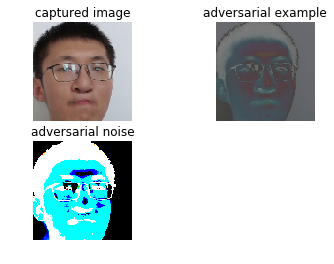

 20%|██        | 1/5 [00:00<00:02,  1.39it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dist: 0.1507, true label: lxj, predicted label: guoth
[[[174 175 173]
  [174 175 173]
  [174 175 173]
  ...
  [173 174 171]
  [174 174 170]
  [173 174 170]]

 [[174 175 173]
  [174 175 173]
  [174 175 173]
  ...
  [173 174 171]
  [174 174 171]
  [173 174 171]]

 [[173 176 173]
  [174 175 173]
  [174 175 173]
  ...
  [173 174 171]
  [173 174 171]
  [173 174 171]]

 ...

 [[190 194 200]
  [191 197 203]
  [192 198 206]
  ...
  [175 175 171]
  [175 175 171]
  [175 175 171]]

 [[190 194 198]
  [191 195 201]
  [192 198 206]
  ...
  [175 175 170]
  [175 175 171]
  [175 175 171]]

 [[191 194 198]
  [191 194 198]
  [191 197 203]
  ...
  [175 175 170]
  [175 175 170]
  [175 175 171]]]


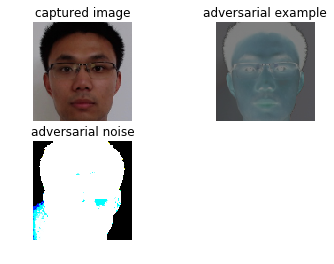

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dist: 0.1866, true label: qiuhy, predicted label: guoth
[[[161 161 160]
  [161 161 160]
  [161 161 160]
  ...
  [162 160 156]
  [162 160 156]
  [161 160 155]]

 [[161 161 160]
  [161 161 160]
  [161 161 160]
  ...
  [162 161 156]
  [162 160 156]
  [162 160 156]]

 [[161 161 160]
  [161 161 160]
  [161 161 160]
  ...
  [162 160 156]
  [161 160 155]
  [161 160 155]]

 ...

 [[190 192 197]
  [190 192 198]
  [191 194 201]
  ...
  [170 168 164]
  [170 168 164]
  [169 168 163]]

 [[190 192 195]
  [191 194 198]
  [191 194 201]
  ...
  [171 169 165]
  [170 168 164]
  [169 168 163]]

 [[191 192 197]
  [191 192 197]
  [191 194 200]
  ...
  [171 169 165]
  [171 169 165]
  [170 168 164]]]


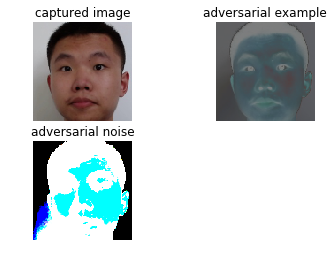

 60%|██████    | 3/5 [00:01<00:01,  1.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dist: 0.1669, true label: zhangwt, predicted label: zyy
[[[107 113 112]
  [109 115 113]
  [109 115 113]
  ...
  [166 165 163]
  [165 165 162]
  [165 165 162]]

 [[109 112 110]
  [106 112 110]
  [109 115 113]
  ...
  [166 165 163]
  [165 165 162]
  [165 165 162]]

 [[110 113 112]
  [110 113 112]
  [112 118 116]
  ...
  [165 165 162]
  [165 165 162]
  [165 165 163]]

 ...

 [[248  47  74]
  [248  47  74]
  [249  49  76]
  ...
  [169 169 165]
  [169 169 165]
  [169 169 165]]

 [[245  44  71]
  [245  44  71]
  [246  46  73]
  ...
  [169 169 165]
  [169 169 165]
  [169 169 165]]

 [[239  38  65]
  [242  41  68]
  [245  44  71]
  ...
  [169 169 165]
  [169 169 165]
  [169 169 165]]]


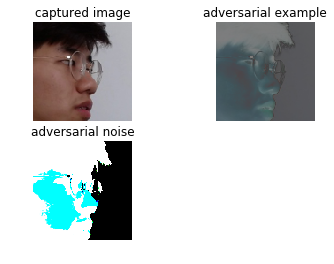

 80%|████████  | 4/5 [00:02<00:00,  1.55it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dist: 0.2104, true label: jinlk, predicted label: guoth
[[[161 161 160]
  [161 161 160]
  [161 161 160]
  ...
  [162 162 158]
  [162 162 158]
  [162 162 158]]

 [[161 161 160]
  [161 161 160]
  [161 161 160]
  ...
  [161 161 157]
  [162 162 158]
  [161 161 157]]

 [[161 161 160]
  [161 161 160]
  [161 161 160]
  ...
  [162 162 158]
  [162 162 158]
  [162 162 158]]

 ...

 [[191 194 198]
  [192 197 201]
  [197 201 209]
  ...
  [168 167 162]
  [168 167 162]
  [167 167 162]]

 [[191 194 198]
  [192 198 203]
  [197 201 209]
  ...
  [168 167 162]
  [168 167 162]
  [168 166 162]]

 [[191 195 200]
  [192 198 203]
  [197 201 209]
  ...
  [168 167 162]
  [168 167 162]
  [168 167 162]]]


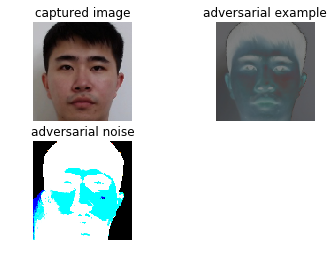

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


(array([[-9.02994256e-03, -3.43276635e-02, -4.80734650e-03,
         -4.88896184e-02,  8.44604671e-02, -6.72346950e-02,
          9.05056223e-02, -5.51461335e-03, -2.73474101e-02,
         -1.98333468e-02,  1.08850496e-02,  3.45346630e-02,
          2.55643539e-02, -1.84383728e-02,  2.38882247e-02,
         -1.44908773e-02,  6.44513965e-02,  3.08985319e-02,
          7.90401537e-04, -6.48811683e-02,  4.21280377e-02,
          4.30818759e-02, -1.34161264e-02,  5.66328205e-02,
         -2.18023732e-02,  1.99933369e-02,  2.74247322e-02,
         -1.75700225e-02,  1.82662334e-03, -5.41485548e-02,
         -3.26005444e-02,  9.40813310e-03,  8.65100995e-02,
          1.44957118e-02,  2.00785827e-02,  7.00715855e-02,
          2.56828517e-02,  4.42714505e-02, -2.27409638e-02,
          1.47620672e-02,  2.52809515e-03, -2.64796615e-02,
         -3.81329097e-03, -8.60658213e-02,  1.32348746e-01,
         -7.76256807e-03, -8.23251903e-02, -1.09849516e-02,
          4.60360274e-02,  8.86756741e-0

In [28]:
index = random.sample(range(len(query_filenames)),5)
print(index)
sample_files = [query_filenames[i] for i in index]
sample_labels = [query_labels[i] for i in index]
extract_attack_feature(model,sample_files,sample_labels)